In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import datetime
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'reply_count': tweet['public_metrics']['reply_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk) (lang:en) -is:retweet',
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 60)  # get 60 minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count'] != 0:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,quote_count,reply_count,retweet_count,text
0,2021-08-10T12:08:43.000Z,1425066578224287745,4.0,0.0,0.0,0.0,Elon Musk is a stupid piece of shit https://t....
1,2021-08-10T12:08:38.000Z,1425066556430577669,1.0,0.0,0.0,0.0,Tesla be like : https://t.co/otuYLiUNBU https:...
2,2021-08-10T12:08:37.000Z,1425066553712603138,1.0,0.0,1.0,0.0,@Tele92275175 @LennartZHH @varbmos @_5HoursAhe...
3,2021-08-10T12:08:30.000Z,1425066524696530949,10.0,0.0,1.0,0.0,@ICannot_Enough Does he live in an alternate r...
4,2021-08-10T12:08:25.000Z,1425066501615144963,1.0,0.0,0.0,0.0,"@Scattered211 Elon Musk, Space Ads, and Crypto..."
...,...,...,...,...,...,...,...
6031,2021-08-04T13:03:36.000Z,1422906063041466368,1.0,0.0,1.0,0.0,@SyN_KevN @brandontan91 Many of the most respe...
6032,2021-08-04T13:03:29.000Z,1422906033878491141,1.0,0.0,0.0,0.0,@RationalEtienne Our AI currently sees $TSLA a...
6033,2021-08-04T13:03:02.000Z,1422905920653254659,1.0,0.0,0.0,0.0,15 Most discussed Stocks on r/wallstreetbets #...
6034,2021-08-04T13:03:00.000Z,1422905912101011456,1.0,0.0,0.0,0.0,Tesla can apply for a portion of the $7.5 bill...


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      + timedelta(hours = 4)).strftime('%Y-%m-%d %H:00:00')) # %H:%M:%S

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == 'NEGATIVE':
        probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
        binary.append(0)
    else:
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
df['probability'] = probs
df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

2021-08-10 12:10:11,467 loading file C:\Users\djlittle\.flair\models\sentiment-en-mix-distillbert_4.pt


,created_at,id,like_count,quote_count,reply_count,retweet_count,text,text_clean,probability,sentiment,binary,Date
0,2021-08-10T12:08:43.000Z,1425066578224287745,4.0,0.0,0.0,0.0,Elon Musk is a stupid piece of shit https://t....,Elon Musk is a stupid piece of shit,-0.999909,NEGATIVE,0,2021-08-10 16:00:00
1,2021-08-10T12:08:38.000Z,1425066556430577669,1.0,0.0,0.0,0.0,Tesla be like : https://t.co/otuYLiUNBU https:...,Tesla be like :,0.985126,POSITIVE,1,2021-08-10 16:00:00
2,2021-08-10T12:08:37.000Z,1425066553712603138,1.0,0.0,1.0,0.0,@Tele92275175 @LennartZHH @varbmos @_5HoursAhe...,"Tesla has 25% of the global EV market, a...",0.991497,POSITIVE,1,2021-08-10 16:00:00
3,2021-08-10T12:08:30.000Z,1425066524696530949,10.0,0.0,1.0,0.0,@ICannot_Enough Does he live in an alternate r...,Does he live in an alternate reality? 🤔or jus...,-0.998125,NEGATIVE,0,2021-08-10 16:00:00
4,2021-08-10T12:08:25.000Z,1425066501615144963,1.0,0.0,0.0,0.0,"@Scattered211 Elon Musk, Space Ads, and Crypto...","Elon Musk, Space Ads, and Crypto (oh my!).......",-0.976875,NEGATIVE,0,2021-08-10 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
6031,2021-08-04T13:03:36.000Z,1422906063041466368,1.0,0.0,1.0,0.0,@SyN_KevN @brandontan91 Many of the most respe...,Many of the most respected people in their f...,0.992463,POSITIVE,1,2021-08-04 17:00:00
6032,2021-08-04T13:03:29.000Z,1422906033878491141,1.0,0.0,0.0,0.0,@RationalEtienne Our AI currently sees $TSLA a...,Our AI currently sees $TSLA as a HOLD (Smart ...,0.719601,POSITIVE,1,2021-08-04 17:00:00
6033,2021-08-04T13:03:02.000Z,1422905920653254659,1.0,0.0,0.0,0.0,15 Most discussed Stocks on r/wallstreetbets #...,15 Most discussed Stocks on r/wallstreetbets #...,-0.624279,NEGATIVE,0,2021-08-04 17:00:00
6034,2021-08-04T13:03:00.000Z,1422905912101011456,1.0,0.0,0.0,0.0,Tesla can apply for a portion of the $7.5 bill...,Tesla can apply for a portion of the $7.5 bill...,-0.982962,NEGATIVE,0,2021-08-04 17:00:00


In [10]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

tsla = yf.Ticker("TSLA")
tsla_stock = tsla.history(
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    interval='1h'
        ).reset_index()
tsla_stock

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-04 09:30:00-04:00,711.000000,718.030029,708.929993,716.610107,4682445,0,0
1,2021-08-04 10:30:00-04:00,717.000000,724.619995,713.450012,719.382507,3983946,0,0
2,2021-08-04 11:30:00-04:00,719.419983,719.799988,712.000000,713.109985,2133612,0,0
3,2021-08-04 12:30:00-04:00,713.304871,716.859985,710.830017,714.210022,1599765,0,0
4,2021-08-04 13:30:00-04:00,714.279907,714.749878,710.020020,710.542297,1083947,0,0
5,2021-08-04 14:30:00-04:00,710.440002,712.599976,708.929993,711.205017,1464314,0,0
6,2021-08-04 15:30:00-04:00,711.260010,711.796997,710.262085,710.909973,916154,0,0
7,2021-08-05 09:30:00-04:00,716.000000,719.689880,711.409973,714.565002,3942067,0,0
8,2021-08-05 10:30:00-04:00,714.390076,720.239990,714.299988,718.500000,2453409,0,0
9,2021-08-05 11:30:00-04:00,718.539978,720.949890,716.199829,717.558594,1537527,0,0


In [11]:
converted = []
for time in tsla_stock['index']:
    converted.append(time.strftime('%Y-%m-%d %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
0,2021-08-04 09:30:00-04:00,711.000000,718.030029,708.929993,716.610107,4682445,0,0,2021-08-04 09:00:00
1,2021-08-04 10:30:00-04:00,717.000000,724.619995,713.450012,719.382507,3983946,0,0,2021-08-04 10:00:00
2,2021-08-04 11:30:00-04:00,719.419983,719.799988,712.000000,713.109985,2133612,0,0,2021-08-04 11:00:00
3,2021-08-04 12:30:00-04:00,713.304871,716.859985,710.830017,714.210022,1599765,0,0,2021-08-04 12:00:00
4,2021-08-04 13:30:00-04:00,714.279907,714.749878,710.020020,710.542297,1083947,0,0,2021-08-04 13:00:00
5,2021-08-04 14:30:00-04:00,710.440002,712.599976,708.929993,711.205017,1464314,0,0,2021-08-04 14:00:00
6,2021-08-04 15:30:00-04:00,711.260010,711.796997,710.262085,710.909973,916154,0,0,2021-08-04 15:00:00
7,2021-08-05 09:30:00-04:00,716.000000,719.689880,711.409973,714.565002,3942067,0,0,2021-08-05 09:00:00
8,2021-08-05 10:30:00-04:00,714.390076,720.239990,714.299988,718.500000,2453409,0,0,2021-08-05 10:00:00
9,2021-08-05 11:30:00-04:00,718.539978,720.949890,716.199829,717.558594,1537527,0,0,2021-08-05 11:00:00


In [12]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,quote_count,reply_count,retweet_count,probability,binary
0,2021-08-04 17:00:00,11.957447,0.063830,0.638298,1.297872,0.082194,0.531915
1,2021-08-04 18:00:00,9.228571,0.371429,1.542857,2.457143,-0.229996,0.371429
2,2021-08-04 19:00:00,20.454545,0.363636,2.204545,2.818182,-0.127955,0.454545
3,2021-08-04 20:00:00,6.029412,0.117647,0.617647,1.176471,0.039463,0.529412
4,2021-08-04 21:00:00,16.166667,0.523810,4.261905,1.785714,0.074045,0.547619
...,...,...,...,...,...,...,...
139,2021-08-10 12:00:00,32.461538,0.615385,1.102564,3.871795,-0.361508,0.307692
140,2021-08-10 13:00:00,7.658537,0.170732,0.658537,0.853659,-0.217351,0.390244
141,2021-08-10 14:00:00,10.058824,0.294118,1.137255,1.470588,-0.156695,0.411765
142,2021-08-10 15:00:00,13.838710,0.032258,1.129032,1.032258,-0.124357,0.419355


In [13]:
means['Date']

0      2021-08-04 17:00:00
1      2021-08-04 18:00:00
2      2021-08-04 19:00:00
3      2021-08-04 20:00:00
4      2021-08-04 21:00:00
              ...         
139    2021-08-10 12:00:00
140    2021-08-10 13:00:00
141    2021-08-10 14:00:00
142    2021-08-10 15:00:00
143    2021-08-10 16:00:00
Name: Date, Length: 144, dtype: object

In [14]:
tsla_stock['Date']

0     2021-08-04 09:00:00
1     2021-08-04 10:00:00
2     2021-08-04 11:00:00
3     2021-08-04 12:00:00
4     2021-08-04 13:00:00
5     2021-08-04 14:00:00
6     2021-08-04 15:00:00
7     2021-08-05 09:00:00
8     2021-08-05 10:00:00
9     2021-08-05 11:00:00
10    2021-08-05 12:00:00
11    2021-08-05 13:00:00
12    2021-08-05 14:00:00
13    2021-08-05 15:00:00
14    2021-08-06 09:00:00
15    2021-08-06 10:00:00
16    2021-08-06 11:00:00
17    2021-08-06 12:00:00
18    2021-08-06 13:00:00
19    2021-08-06 14:00:00
20    2021-08-06 15:00:00
21    2021-08-09 09:00:00
22    2021-08-09 10:00:00
23    2021-08-09 11:00:00
24    2021-08-09 12:00:00
25    2021-08-09 13:00:00
26    2021-08-09 14:00:00
27    2021-08-09 15:00:00
Name: Date, dtype: object

In [15]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,quote_count,reply_count,retweet_count,probability,binary,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-05 09:00:00,7.531915,0.042553,1.000000,0.617021,0.130403,0.574468,2021-08-05 09:30:00-04:00,716.000000,719.689880,711.409973,714.565002,3942067,0,0
1,2021-08-05 10:00:00,9.600000,0.200000,0.400000,0.755556,0.165972,0.600000,2021-08-05 10:30:00-04:00,714.390076,720.239990,714.299988,718.500000,2453409,0,0
2,2021-08-05 11:00:00,4.195652,0.086957,0.630435,0.673913,-0.167790,0.413043,2021-08-05 11:30:00-04:00,718.539978,720.949890,716.199829,717.558594,1537527,0,0
3,2021-08-05 12:00:00,3.000000,0.022222,0.355556,0.666667,0.038071,0.511111,2021-08-05 12:30:00-04:00,717.650024,718.139893,713.859985,714.630005,1313326,0,0
4,2021-08-05 13:00:00,11.500000,0.111111,0.583333,1.555556,-0.158828,0.416667,2021-08-05 13:30:00-04:00,714.630005,715.669983,713.210022,714.205017,1246175,0,0
5,2021-08-05 14:00:00,35.380952,0.428571,1.500000,3.619048,-0.043493,0.476190,2021-08-05 14:30:00-04:00,714.130005,716.559875,713.630005,714.599976,935516,0,0
6,2021-08-05 15:00:00,16.644444,0.155556,1.222222,2.000000,-0.084205,0.466667,2021-08-05 15:30:00-04:00,714.559998,714.960022,713.359985,714.630005,921255,0,0
7,2021-08-06 09:00:00,11.000000,0.222222,1.155556,1.422222,-0.035187,0.488889,2021-08-06 09:30:00-04:00,711.900024,716.330017,708.000000,709.789978,3385159,0,0
8,2021-08-06 10:00:00,27.342105,0.263158,2.421053,1.815789,-0.180145,0.394737,2021-08-06 10:30:00-04:00,709.809998,710.929993,697.630005,703.521118,3863940,0,0
9,2021-08-06 11:00:00,18.793103,0.034483,0.862069,2.896552,-0.023316,0.482759,2021-08-06 11:30:00-04:00,703.349976,705.320007,700.669983,704.524170,1680626,0,0


In [16]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.49472669148013054

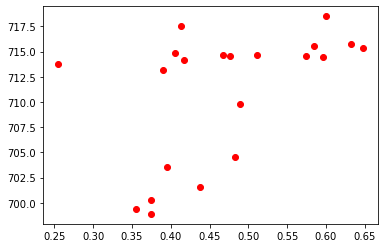

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')